In [2]:
 import tensorflow as tf
 

In [3]:
from tensorflow.keras.applications.vgg19 import VGG19

In [4]:
model=VGG19(
    include_top=False,
    weights ='imagenet'
)
model.trainable=False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [5]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
def imgpreprocess(image_path):
  img=load_img(image_path)
  img=img_to_array(img)
  img=preprocess_input(img)
  img=np.expand_dims(img,axis=0)
  return img

In [54]:
def deprocess(y):
  y[:,:,0]+=103.939
  y[:,:,1]+=116.779
  y[:,:,2]+=123.68
  y=y[:,:,::-1]
  y=np.clip(y,0,255).astype('uint8')
  return y

def displayimg(img):
  if len(img.shape)==4:
    img=np.squeeze(img,axis=0)
  img=deprocess(img)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  return


In [8]:
content_layer='block5_conv2'
style_layers=[
            'block1_conv1',
            'block3_conv1',
            'block5_conv1'
]
content_model=Model(inputs=model.input,outputs=model.get_layer(content_layer).output)
style_model=[Model(inputs=model.input,outputs=model.get_layer(layer).output) for layer in style_layers]

In [9]:
def content_cost(content,generated):
  a_C=content_model(content)
  a_G=content_model(generated)
  cost=tf.reduce_mean(tf.square(a_C-a_G))
  return cost

def gram_matrix(A):
  n_C=int(A.shape[-1])
  a=tf.reshape(A,[-1,n_C])
  n=tf.shape(a)[0]
  G=tf.matmul(a,a,transpose_a=True)
  return G/tf.cast(n,dtype='float32')


  


In [17]:
lam=.1/len(style_model)#calculating weights assuming each style_model is same

def style_cost(style,generated):
  J_style=0
  for style_mode in style_model:
    aSS=style_mode(style)
    aGG=style_mode(generated)
    GS=gram_matrix(aSS)
    GG=gram_matrix(aGG)
    current_cost=tf.reduce_mean(tf.square(GS-GG))
    J_style+=current_cost
  return J_style


In [67]:
import time
generated_images=[]
def Trainingloop(content_path,style_path,iteration=20,alpha=.10,beta=.20):
  content=imgpreprocess(content_path)
  style=imgpreprocess(style_path)
  generated=tf.Variable(content,dtype=tf.float32)
  opti=tf.optimizers.Adam(learning_rate=7.)
  best_cost=1e12+0.1
  best_image=None
  start_time=time.time()

  for i in range(iteration):
    with tf.GradientTape() as tape:
      J_content=content_cost(content,generated)
      J_style=style_cost(style,generated)
      J_total=alpha*J_content+beta*J_style
      grads=tape.gradient(J_total,generated)
      opti.apply_gradients([(grads,generated)])

    if J_total<best_cost:
      best_cost=J_total
      best_image=generated.numpy()
    if i % int(iteration/10) == 0:
          time_taken = time.time() - start_time
          print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
          generated_images.append(generated.numpy())
    
  return best_image



  

In [14]:
from google.colab import files
contentimg=files.upload()

Saving download.jpg to download.jpg


In [15]:
from google.colab import files
styleimg=files.upload()

Saving pain (1).jpg to pain (1).jpg


In [68]:
best_img=Trainingloop('download.jpg','pain (1).jpg')

Cost at 0: 4513872896.0. Time elapsed: 0.5177168846130371
Cost at 2: 2646798592.0. Time elapsed: 1.3528096675872803
Cost at 4: 1006041024.0. Time elapsed: 2.1870810985565186
Cost at 6: 921412992.0. Time elapsed: 3.0223958492279053
Cost at 8: 650275200.0. Time elapsed: 3.8559160232543945
Cost at 10: 402779872.0. Time elapsed: 4.688210487365723
Cost at 12: 359518752.0. Time elapsed: 5.526274681091309
Cost at 14: 294919520.0. Time elapsed: 6.358016490936279
Cost at 16: 208514048.0. Time elapsed: 7.190046310424805
Cost at 18: 187993840.0. Time elapsed: 8.022079467773438


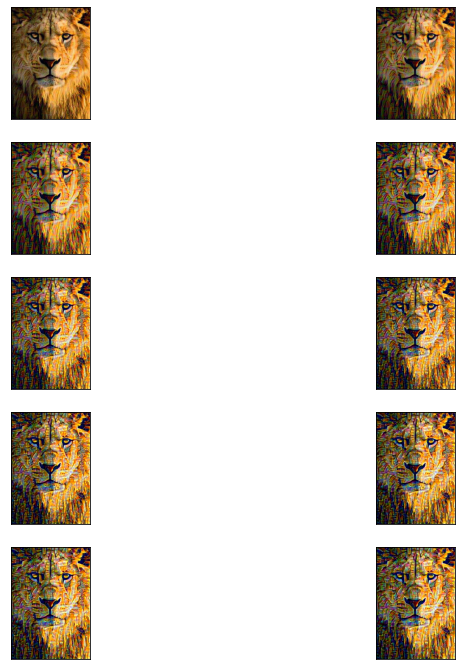

In [69]:
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    displayimg(generated_images[i])
plt.show()
